In [146]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Define Color Pallette for visualizations
deloitte_green = '#86BC25' #007681
deloitte_darkgray = '#212721'
deloitte_lightgray = '#D9D9D6'
deloitte_black = '#000000'
deloitte_palette = [deloitte_green, deloitte_darkgray, deloitte_lightgray, deloitte_black]
sns.set_palette(sns.color_palette(deloitte_palette))
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.edgecolor': deloitte_darkgray,
    'axes.labelcolor': deloitte_darkgray,
    'xtick.color': deloitte_darkgray,
    'ytick.color': deloitte_darkgray,
    'text.color': deloitte_darkgray,
    'axes.titleweight': 'bold',
    'axes.titlecolor': deloitte_green,
    'figure.facecolor': 'white'
})


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report,f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv('fraud.csv')
df.shape

(594643, 10)

<h1>EDA</h1>

In [4]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [5]:
# No Duplicate Rows
df.duplicated().sum()

0

In [6]:
# Check Null Values
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [7]:
df.dtypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

In [8]:
# Remove quotes from all object columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip("'")
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


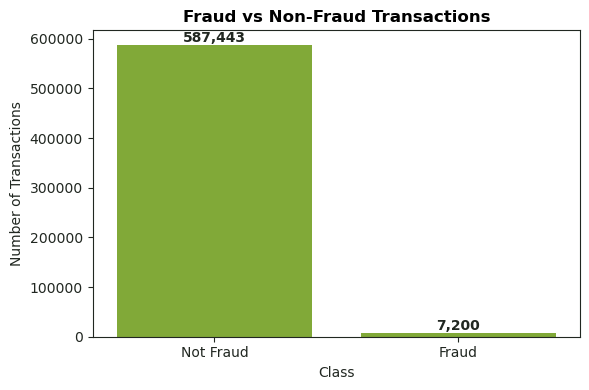

In [9]:
vc = df['fraud'].value_counts()

# Barplot
plt.figure(figsize=(6,4))
sns.barplot(x=vc.index, y=vc.values)
plt.xticks([0,1], ['Not Fraud','Fraud'])
plt.title('Fraud vs Non-Fraud Transactions', color='black')  # Set title color to black
plt.ylabel('Number of Transactions')
plt.xlabel('Class')
for i, v in enumerate(vc.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', color=deloitte_darkgray, fontweight='bold')
plt.tight_layout()
plt.show()

<p><b>Extreme</b> imbalance in the data. <b>1.2%</b> are fraud.</p>

In [11]:
len(df['step'].value_counts())

180

<p>As per the word document, the <b>Step</b> columns is a time colummn which refers to an hour. However, if we were to create some columns based on it such as hour, day of week etc.., we will end up with 7 & a half days. Thus, I won't be creating such columns.</p>
<p>I won't drop it as it still can be useful in creating features such as the number of steps since last transaction per customer, merchant etc..</p>

In [13]:
# Unique Customers
len(df['customer'].value_counts())

4112

In [14]:
# Unique Merchants
len(df['merchant'].value_counts())

50

In [15]:
# Unique Categories
len(df['category'].value_counts())

15

In [17]:
# Age
df['age'].value_counts()

age
2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
0      2452
U      1178
Name: count, dtype: int64

In [18]:
df['zipMerchant'].value_counts()

zipMerchant
28007    594643
Name: count, dtype: int64

In [21]:
df['zipcodeOri'].value_counts()

zipcodeOri
28007    594643
Name: count, dtype: int64

In [22]:
#zipMerchant & zipcodeOri columns have no variance - Same value for all rows - Will be dropped
df.drop('zipcodeOri', axis=1, inplace= True)
df.drop('zipMerchant', axis=1, inplace= True)

In [24]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [25]:
# Define Age mapping for EDA purposes
age_map = {
    '0': '<=18',
    '1': '19-25',
    '2': '26-35',
    '3': '36-45',
    '4': '46-55',
    '5': '56-65',
    '6': '>65',
    'U': 'U'
}

df['AGE_RANGE'] = df['age'].map(age_map)
df.head()

,step,customer,age,gender,merchant,category,amount,fraud,AGE_RANGE
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0,46-55
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0,26-35
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0,46-55
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0,36-45
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0,56-65


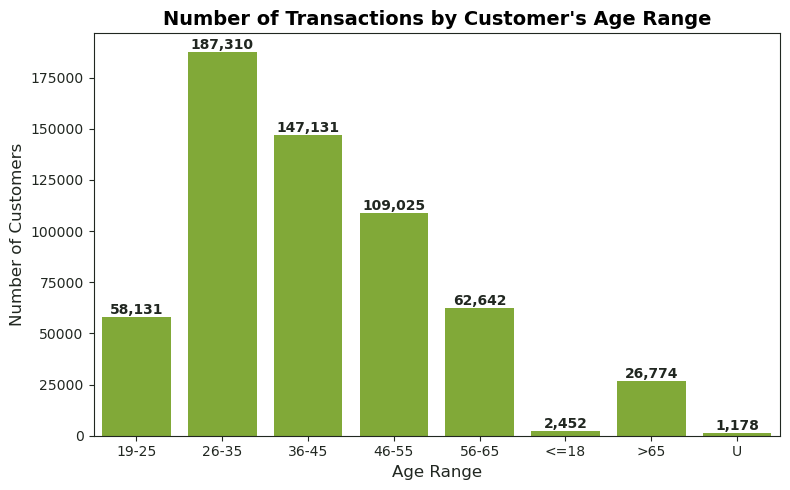

In [28]:
# Count of each age range
vc = df['AGE_RANGE'].value_counts().sort_index()  # keeps order 0-6

plt.figure(figsize=(8,5))
sns.barplot(x=vc.index, y=vc.values)

plt.title("Number of Transactions by Customer's Age Range", color=deloitte_black, fontsize=14)
plt.xlabel('Age Range', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add counts on top of bars
for i, v in enumerate(vc.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', color=deloitte_darkgray, fontweight='bold')

plt.tight_layout()
plt.show()

<p>The highest transaction counts are for customers with age ranges of 26-35 followed by 36-45. The lowest transaction counts is for customers <=18 & Unknown. </p>

In [30]:
# # Calculate fraud % per age range
# fraud_age = df.groupby('AGE_RANGE')['fraud'].mean().sort_index()

# plt.figure(figsize=(8,5))
# sns.barplot(x=fraud_age.index, y=fraud_age.values, color=deloitte_green)

# # Title and labels
# plt.title("Percentage of Fraudulent Transactions by Age Range", color=deloitte_black, fontsize=14)
# plt.xlabel('Age Range', color=deloitte_darkgray, fontsize=12)
# plt.ylabel('Fraud Rate', color=deloitte_darkgray, fontsize=12)

# # Add percentages on top of bars
# for i, v in enumerate(fraud_age.values):
#     plt.text(i, v + 0.000005, f'{v*100:.2f}%', ha='center', va='bottom', color=deloitte_darkgray, fontweight='bold')

# plt.tight_layout()
# plt.show()


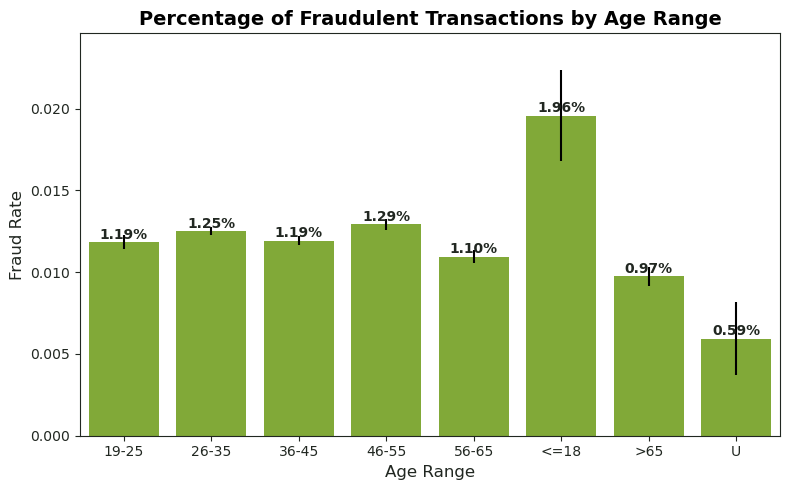

In [31]:
# Calculate mean fraud rate and count per age range
fraud_age = df.groupby('AGE_RANGE')['fraud'].agg(['mean', 'count']).sort_index()
fraud_age['std_err'] = np.sqrt(fraud_age['mean'] * (1 - fraud_age['mean']) / fraud_age['count'])

plt.figure(figsize=(8,5))
sns.barplot(
    x=fraud_age.index, 
    y=fraud_age['mean'], 
    color=deloitte_green,
    yerr=fraud_age['std_err'].values  # add error bars
)

# Title and labels
plt.title("Percentage of Fraudulent Transactions by Age Range", color=deloitte_black, fontsize=14)
plt.xlabel('Age Range', color=deloitte_darkgray, fontsize=12)
plt.ylabel('Fraud Rate', color=deloitte_darkgray, fontsize=12)

# Add percentages on top of bars
for i, v in enumerate(fraud_age['mean']):
    plt.text(i, v + 0.00002, f'{v*100:.2f}%', ha='center', va='bottom', color=deloitte_darkgray, fontweight='bold')

plt.ylim(0, max(fraud_age['mean'] + fraud_age['std_err'])*1.1)  
plt.tight_layout()
plt.show()


<p>Customers of Ages<=18 have the highest percentage of fraudulent transactions. However, theyre the amount to the least amount of transactions compared to the other age buckets. (Excluding Customers with an Unknown age)</p>
<p>The lines on the bars represent error bars. The longer they are means the less samples available in the data. Thus uncertain as '<=18'. Also, if they overlap then the difference of the categories is statistically insignificant. For our case we have 2 options from the upper vis. The first option is ordinal encoding the ages based on the order of age buckets & the 2nd is ordinal encoding them based on the percentages.</p>

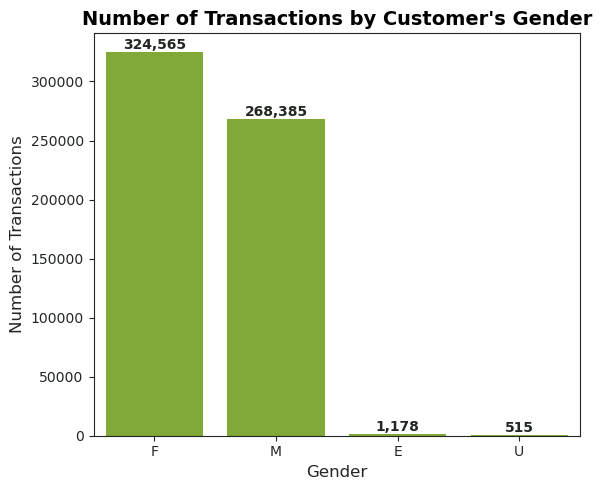

In [33]:
# Count of each gender
vc = df['gender'].value_counts()

plt.figure(figsize=(6,5))
sns.barplot(x=vc.index, y=vc.values, color=deloitte_green) 

# Title and labels
plt.title("Number of Transactions by Customer's Gender", color=deloitte_black, fontsize=14)
plt.xlabel('Gender', color=deloitte_darkgray, fontsize=12)
plt.ylabel('Number of Transactions', color=deloitte_darkgray, fontsize=12)

# Add counts on top of bars
for i, v in enumerate(vc.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', color=deloitte_darkgray, fontweight='bold')

plt.tight_layout()
plt.show()


In [35]:
# df[df['gender']=='U']['fraud'].value_counts() # All 0
# df[df['gender']=='E']['fraud'].value_counts() # 7 Fraud
# df[df['gender']=='M']['fraud'].value_counts() # 2435 Fraud
# df[df['gender']=='F']['fraud'].value_counts() # 4758 Fraud

<p>Usually including gender in ML models would introduce bias. However, in some cases it can be included in combination with other features for personalised product offerings etcc..</p>
<p><b>For this model I will be dropping it</b></p>

In [40]:
df.drop('gender', axis=1, inplace = True)

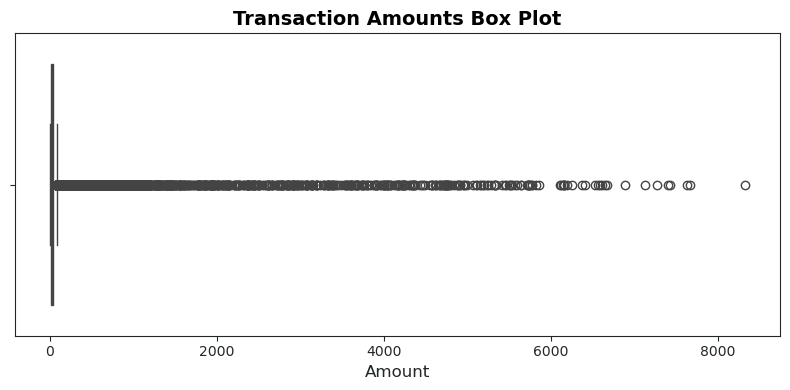

In [44]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['amount'], color=deloitte_green)

plt.title('Transaction Amounts Box Plot', color=deloitte_black, fontsize=14)
plt.xlabel('Amount', color=deloitte_darkgray, fontsize=12)

plt.tight_layout()
plt.show()

<p>Transaction amounts include outliers.</p>

In [51]:
df.head()

,step,customer,age,merchant,category,amount,fraud,AGE_RANGE
0,0,C1093826151,4,M348934600,es_transportation,4.55,0,46-55
1,0,C352968107,2,M348934600,es_transportation,39.68,0,26-35
2,0,C2054744914,4,M1823072687,es_transportation,26.89,0,46-55
3,0,C1760612790,3,M348934600,es_transportation,17.25,0,36-45
4,0,C757503768,5,M348934600,es_transportation,35.72,0,56-65


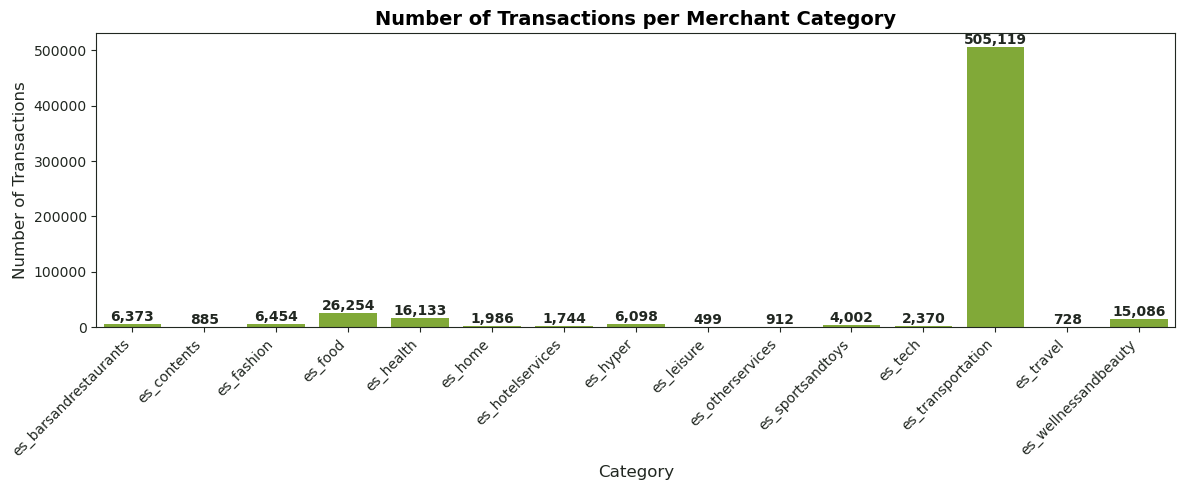

In [52]:
# Calculate fraud % and standard error per Merhcant Category
fraud_stats = df.groupby('category')['fraud'].agg(['mean', 'count'])
fraud_stats['std_err'] = np.sqrt(fraud_stats['mean'] * (1 - fraud_stats['mean']) / fraud_stats['count'])

# Number of transactions per Merchant Category
plt.figure(figsize=(12,5))
sns.barplot(x=fraud_stats.index, y=fraud_stats['count'], color=deloitte_green)

plt.title('Number of Transactions per Merchant Category', color=deloitte_black, fontsize=14)
plt.xlabel('Category', color=deloitte_darkgray, fontsize=12)
plt.ylabel('Number of Transactions', color=deloitte_darkgray, fontsize=12)
plt.xticks(rotation=45, ha='right', color=deloitte_darkgray)

# Add transaction counts on top of bars
for i, v in enumerate(fraud_stats['count']):
    plt.text(i, v + 5, f'{v:,}', ha='center', va='bottom', color=deloitte_darkgray, fontweight='bold')

plt.tight_layout()
plt.show()


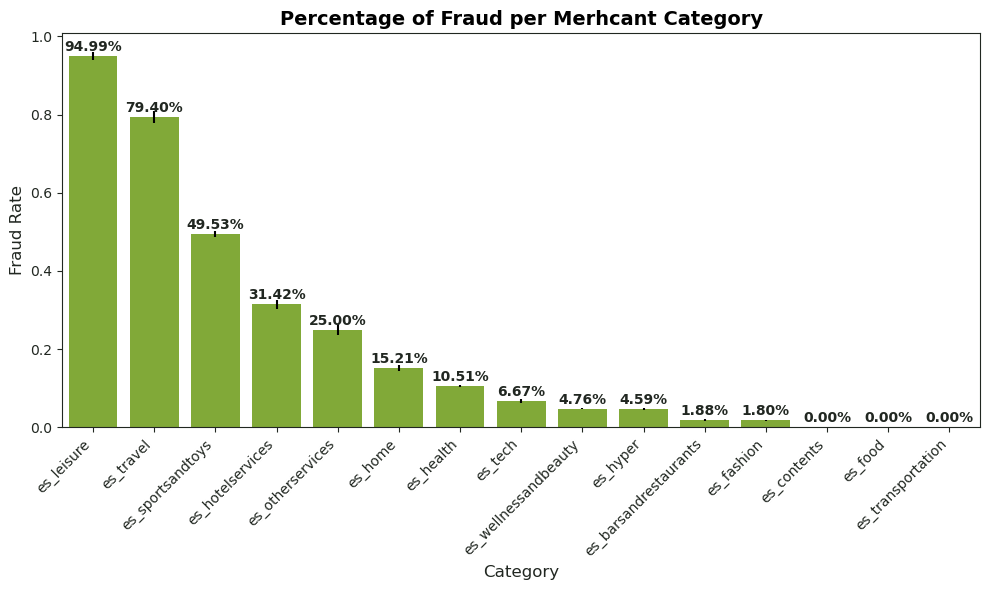

In [55]:
# Sort categories by fraud %
fraud_stats = fraud_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x=fraud_stats.index, 
    y=fraud_stats['mean'], 
    yerr=fraud_stats['std_err'],  # Error bars
    color=deloitte_green
)

# Title and labels
plt.title('Percentage of Fraud per Merhcant Category', color=deloitte_black, fontsize=14)
plt.xlabel('Category', color=deloitte_darkgray, fontsize=12)
plt.ylabel('Fraud Rate', color=deloitte_darkgray, fontsize=12)
plt.xticks(rotation=45, ha='right', color=deloitte_darkgray)

# Add percentages on top of bars
for i, v in enumerate(fraud_stats['mean']):
    plt.text(i, v + 0.005, f'{v*100:.2f}%', ha='center', va='bottom', color=deloitte_darkgray, fontweight='bold')

plt.tight_layout()
plt.show()

In [57]:
# Sanity Check
df[df['category']=='es_transportation']['fraud'].value_counts()

fraud
0    505119
Name: count, dtype: int64

In [58]:
# Sanity Check
df[df['category']=='es_food']['fraud'].value_counts()

fraud
0    26254
Name: count, dtype: int64

In [59]:
# Sanity Check
df[df['category']=='es_contents']['fraud'].value_counts()

fraud
0    885
Name: count, dtype: int64

<h3>Important Insight</h3>
<p>Merchant Categories of es_contents, es_food & es_transportation have no fraudulent transations & they make up to the majority of the 0 class. If we dont include those merchants in the modeling it would reduce reduce imbalance. However, if a fraud was to occur in the future with such merchants our model might not be able to classify it as fraudulent. Thus, I will be creating a new feature called <b>MERCHANT_CATEGORY_RISK</b> which will classify merchant groups by their risk level which will be included in the model</p>

In [64]:
df['category'].unique()

array(['es_transportation', 'es_health', 'es_otherservices', 'es_food',
       'es_hotelservices', 'es_barsandrestaurants', 'es_tech',
       'es_sportsandtoys', 'es_wellnessandbeauty', 'es_hyper',
       'es_fashion', 'es_home', 'es_contents', 'es_travel', 'es_leisure'],
      dtype=object)

In [65]:
# Create MERCHANT_CATEGORY_RISK 
merchant_category_map = {
    'es_transportation': 0,
    'es_food': 0,
    'es_contents': 0,
    'es_fashion': 1,
    'es_barsandrestaurants': 1,
    'es_hyper': 2,
    'es_wellnessandbeauty': 2,
    'es_tech': 2,
    'es_health': 3,
    'es_home': 3,
    'es_otherservices': 4,
    'es_hotelservices': 4,
    'es_sportsandtoys':5,
    'es_travel':6,
    'es_leisure': 7
}

df['MERCHANT_CATEGORY_RISK'] = df['category'].map(merchant_category_map)
df.head()

,step,customer,age,merchant,category,amount,fraud,AGE_RANGE,MERCHANT_CATEGORY_RISK
0,0,C1093826151,4,M348934600,es_transportation,4.55,0,46-55,0
1,0,C352968107,2,M348934600,es_transportation,39.68,0,26-35,0
2,0,C2054744914,4,M1823072687,es_transportation,26.89,0,46-55,0
3,0,C1760612790,3,M348934600,es_transportation,17.25,0,36-45,0
4,0,C757503768,5,M348934600,es_transportation,35.72,0,56-65,0


<p><b>Note: </b> I won't be diving into merchants themselves as new merchants will emerge in the future and we want the model to generalize. Thus, the engineered feature of <b>MERCHANT_CATEGORY_RISK</b> is enough. Also, if a specific merchant had all transactions as fraudulent they would be flagged by normal fraud detection systems. (I would double check that in a practical use case with the Business, AML or Client)</p>

In [67]:
# Drop Merchant Column
df.drop('merchant', axis=1, inplace=True)

In [68]:
df.dtypes

step                        int64
customer                   object
age                        object
category                   object
amount                    float64
fraud                       int64
AGE_RANGE                  object
MERCHANT_CATEGORY_RISK      int64
dtype: object

In [69]:
# Mapping unknown ages to -1 --  we can also drop them if the percentage of fraud wasnt high. (Its half the rate of all. But gonna keep em for now)
# Convert age to numeric - null will be returned for u
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Replace NaN(U) with -1
df['age'] = df['age'].fillna(-1).astype(int)

In [70]:
df['age'].value_counts()

age
 2    187310
 3    147131
 4    109025
 5     62642
 1     58131
 6     26774
 0      2452
-1      1178
Name: count, dtype: int64

<p>I won't be OneHotEncoding the age since it has an ordinal meaning. Also, having one column representing that is better than having multiple ones since I'm gonna train on tree based models since they're robust to outliers (amount), and they support imbalance with some parameters instead of using SMOTE and other oversampling/undersampling techniques. I will be trying both bagging and boosting models.</p>

<p>If I were to use neural networks. I would OneHOtEncode those features. However, for now I will be testing tree based first and depending on the results I will decide if we need to expirement with deep learning models or not. Since fraud detection models are mostly for banks & in the banking industry explainability is important as per ML & AI regulations depending on the country.</p>

In [72]:
df.dtypes

step                        int64
customer                   object
age                         int32
category                   object
amount                    float64
fraud                       int64
AGE_RANGE                  object
MERCHANT_CATEGORY_RISK      int64
dtype: object

In [73]:
df.isnull().sum()

step                      0
customer                  0
age                       0
category                  0
amount                    0
fraud                     0
AGE_RANGE                 0
MERCHANT_CATEGORY_RISK    0
dtype: int64

<h4>Engineering Time Based Features</h4>

In [79]:
df_time_details = df.copy()

# Sort once by customer and step
df_time_details = df_time_details.sort_values(['customer', 'step']).copy()

# Hours since last transaction per customer
df_time_details['HOUR_SINCE_LAST_TXN_CUSTOMER'] = (
    df_time_details.groupby('customer')['step'].diff()
)

# Function to compute last-24h features vectorised per customer
def last_24h_features(group, window_hours=24):
    steps = group['step'].values
    amounts = group['amount'].values
    n = len(group)

    # index of first transaction >= step - 24
    start_idx = np.searchsorted(steps, steps - window_hours, side='left')

    # counts
    counts = np.arange(1, n + 1) - start_idx + 0  # inclusive count

    # sums & average via cumulative sum
    csum = np.cumsum(amounts)
    csum_shifted = np.concatenate(([0.0], csum[:-1]))
    sum_window = csum - csum_shifted[start_idx]
    avg_window = sum_window / counts

    group['TRANSACTIONS_COUNT_LAST_24H_CUSTOMER'] = counts
    group['AVG_AMOUNT_LAST_24H_CUSTOMER'] = avg_window
    return group

# Apply per customer
df_time_details = (
    df_time_details
    .groupby('customer', group_keys=False)
    .apply(last_24h_features, window_hours=24)
)

# Restore original index order
df_time_details = df_time_details.sort_index()

C:\Users\User\AppData\Local\Temp\ipykernel_13028\3119964050.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(last_24h_features, window_hours=24)


In [82]:
df_time_details.shape

(594643, 11)

In [85]:
df_time_details = df_time_details.sort_index()
df_time_details.head()

,step,customer,age,category,amount,fraud,AGE_RANGE,MERCHANT_CATEGORY_RISK,HOUR_SINCE_LAST_TXN_CUSTOMER,TRANSACTIONS_COUNT_LAST_24H_CUSTOMER,AVG_AMOUNT_LAST_24H_CUSTOMER
0,0,C1093826151,4,es_transportation,4.55,0,46-55,0,NaN,1,4.55
1,0,C352968107,2,es_transportation,39.68,0,26-35,0,NaN,1,39.68
2,0,C2054744914,4,es_transportation,26.89,0,46-55,0,NaN,1,26.89
3,0,C1760612790,3,es_transportation,17.25,0,36-45,0,NaN,1,17.25
4,0,C757503768,5,es_transportation,35.72,0,56-65,0,NaN,1,35.72


In [87]:
df_time_details.isna().sum()

step                                       0
customer                                   0
age                                        0
category                                   0
amount                                     0
fraud                                      0
AGE_RANGE                                  0
MERCHANT_CATEGORY_RISK                     0
HOUR_SINCE_LAST_TXN_CUSTOMER            4112
TRANSACTIONS_COUNT_LAST_24H_CUSTOMER       0
AVG_AMOUNT_LAST_24H_CUSTOMER               0
dtype: int64

In [90]:
#HOUR_SINCE_LAST_TXN_CUSTOMER: Number of steps since the customer's last transaction. (-1 if they had no previous transaction)(0 if they had a transaction previously during the same step/hour).
df_time_details['HOUR_SINCE_LAST_TXN_CUSTOMER'] = df_time_details['HOUR_SINCE_LAST_TXN_CUSTOMER'].fillna(-1)

In [91]:
df_time_details.isna().sum()

step                                    0
customer                                0
age                                     0
category                                0
amount                                  0
fraud                                   0
AGE_RANGE                               0
MERCHANT_CATEGORY_RISK                  0
HOUR_SINCE_LAST_TXN_CUSTOMER            0
TRANSACTIONS_COUNT_LAST_24H_CUSTOMER    0
AVG_AMOUNT_LAST_24H_CUSTOMER            0
dtype: int64

In [95]:
# Write df_time_details to CSV for sanity check, If the data was larger I would take a sample to verify
df_time_details.to_csv('df_time_details.csv', index=False)

<h4><b>Time(Step) Based Engineered Features </b></h4>
<li><b>HOUR_SINCE_LAST_TXN_CUSTOMER:</b> Number of steps since the customer's last transaction. (-1 if they had no previous transaction)(0 if they had a transaction previously during the same step/hour).</li>
<li><b>TRANSACTIONS_COUNT_LAST_24H_CUSTOMER:</b> Number of transactions done by the customer in the past 24 steps.</li>
<li><b>AVG_AMOUNT_LAST_24H_CUSTOMER:</b> Average transaction amount in the past 24 steps for the customer.</li>

<p>The above features would be available to be created production based on historical data. Thus, egineering the time windows before splitting the data isn't considered data leakage.</p>

In [99]:
features_to_drop = ['customer','category','AGE_RANGE']

for col in features_to_drop:
    df_time_details.drop(col, axis=1, inplace=True)
#Step will be dropped after splitting based on order of time

In [100]:
df_time_details.dtypes

step                                      int64
age                                       int32
amount                                  float64
fraud                                     int64
MERCHANT_CATEGORY_RISK                    int64
HOUR_SINCE_LAST_TXN_CUSTOMER            float64
TRANSACTIONS_COUNT_LAST_24H_CUSTOMER      int64
AVG_AMOUNT_LAST_24H_CUSTOMER            float64
dtype: object

C:\Users\User\AppData\Local\Temp\ipykernel_13028\186956917.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


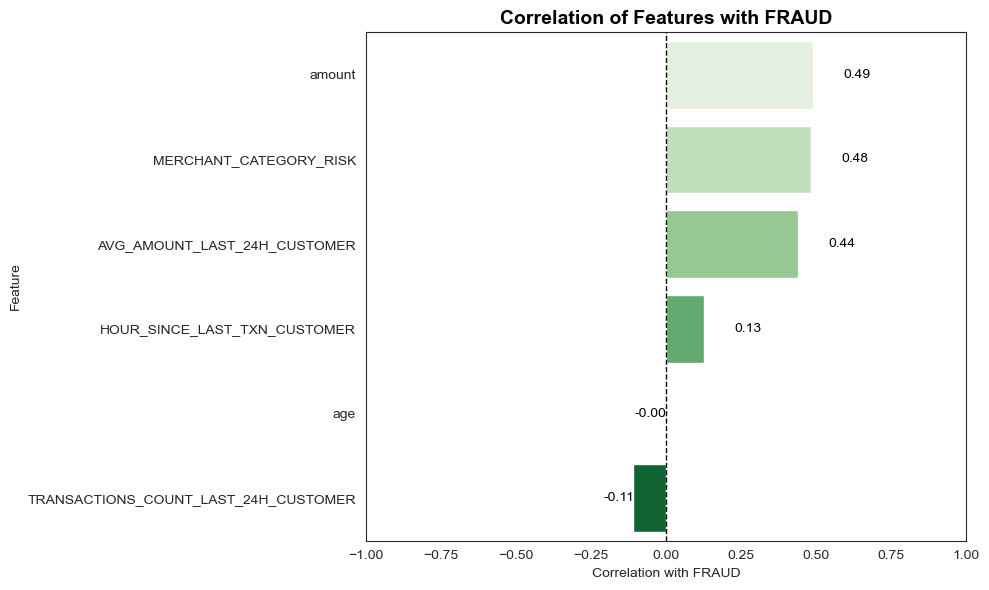

In [101]:
numeric_features = [
    'age',
    'amount',
    'MERCHANT_CATEGORY_RISK',
    'HOUR_SINCE_LAST_TXN_CUSTOMER',
    'TRANSACTIONS_COUNT_LAST_24H_CUSTOMER',
    'AVG_AMOUNT_LAST_24H_CUSTOMER'
]

# Correlations with target
corr_with_fraud = df_time_details[numeric_features + ['fraud']].corr()['fraud'].drop('fraud')
corr_with_fraud = corr_with_fraud.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("white")  # remove background grid
ax = sns.barplot(
    x=corr_with_fraud.values,
    y=corr_with_fraud.index,
    palette='Greens'
)
for i, v in enumerate(corr_with_fraud.values):
    ax.text(v + 0.1 if v >= 0 else v - 0.1, i, f"{v:.2f}", color=deloitte_black, va='center')
plt.title('Correlation of Features with FRAUD', color=deloitte_black, fontsize=14)
plt.xlabel('Correlation with FRAUD', color=deloitte_darkgray)
plt.ylabel('Feature', color=deloitte_darkgray)
plt.xlim(-1, 1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

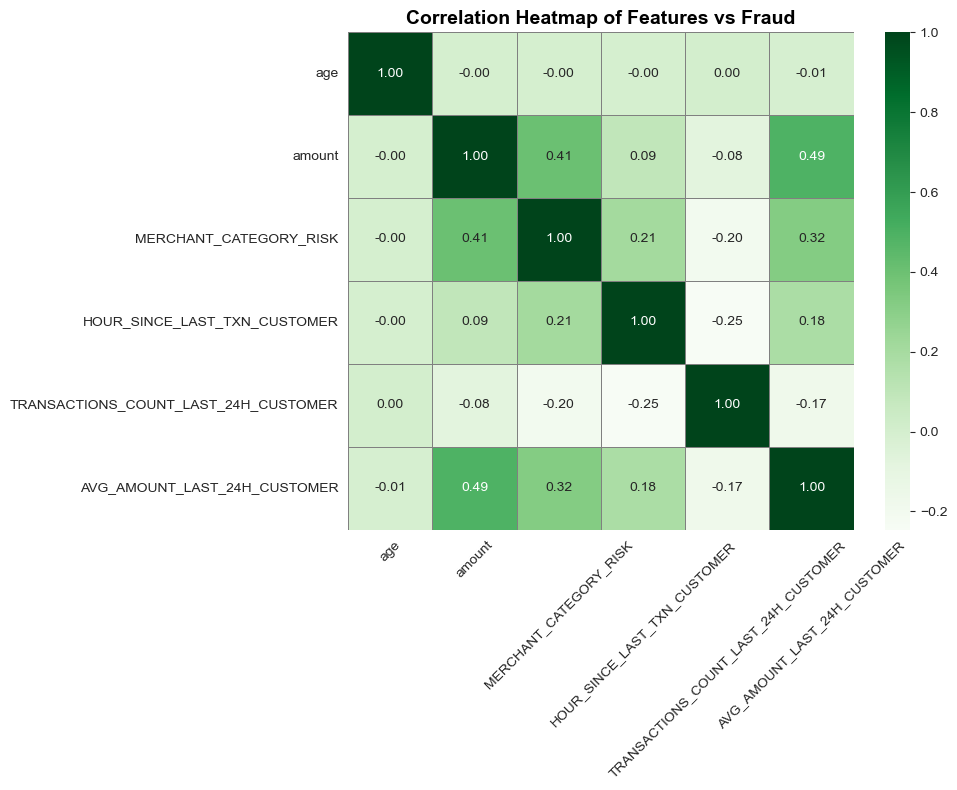

In [102]:
corr_matrix = df_time_details[numeric_features].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    cbar=True,
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Correlation Heatmap of Features vs Fraud", fontsize=14, color=deloitte_black)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h3>Train Test Split</h3>

In [104]:
# Sort on Step - Double Check
df_time_details = df_time_details.sort_values('step').copy()

# Step Cutoff for 80/20 split
step_cutoff = df_time_details['step'].quantile(0.8)

# Train = all steps <= cutoff, Test = steps > cutoff
train_df = df_time_details[df_time_details['step'] <= step_cutoff].copy()
test_df = df_time_details[df_time_details['step'] > step_cutoff].copy()

# Sanity Check
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
# Stratification Check
print(f"Train fraud ratio: {train_df['fraud'].mean():.4f}, Test fraud ratio: {test_df['fraud'].mean():.4f}") 

Train shape: (476005, 8), Test shape: (118638, 8)
Train fraud ratio: 0.0124, Test fraud ratio: 0.0108


<p>Minor Drop in the test fraud ratio due to the rows in the latest steps having a higher amount of 0's than 1's worth noting.</p>

In [141]:
# # Sanity Check
# train_df['step'].value_counts() # Train df Steps 0-147
# test_df['step'].value_counts() # Test DF Steps 148-179

In [105]:
# Features & Target
X_train = train_df.drop(columns=['fraud','step']) # Step was used to split the data in order of time so training on the first n steps and testing on after 
y_train = train_df['fraud']

# Features & target for testing
X_test = test_df.drop(columns=['fraud','step'])
y_test = test_df['fraud']

In [112]:
print('X Train Shape: ', X_train.shape)
print('Y Train Shape: ', y_train.shape)
print('X Test Shape', X_test.shape)
print('Y Test Shape',y_test.shape)

X Train Shape:  (476005, 6)
Y Train Shape:  (476005,)
X Test Shape (118638, 6)
Y Test Shape (118638,)


<h1>Modeling</h1>

<h3>Random Forest</h3>

In [147]:
# Baseline Random Forest
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Training
rf_baseline.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [200]:
# Probabilities (positive class)
y_proba_rf = rf_baseline.predict_proba(X_test)[:, 1]

# Threshold 
rf_threshold = 0.5

# Apply threshold to get class labels
y_pred_rf = (y_proba_rf >= rf_threshold).astype(int)

# Metrics
print(classification_report(y_test, y_pred_rf))
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC Score (Random Forest): {auc_rf:.4f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.91      0.69      0.78      1280

    accuracy                           1.00    118638
   macro avg       0.95      0.84      0.89    118638
weighted avg       1.00      1.00      1.00    118638

AUC Score (Random Forest): 0.9682


<p>The Baseline Random Forest model performed well on the test data. For fraud detection models usually we should optimize towards a better recall. However, in practical cases I would consult with the business/client to check their input regarding the expectations for precision & recall of the model & optimize towards that. Since False Positives would be costly & False negatives are risky.</p>

<h3>Random Forest GirdSearchCV</h3>

In [190]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced'] 
}

# use stratified 5-fold CV (better for imbalanced classes)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',  
    n_jobs=-1,
    verbose=2
)

# fit on training data
grid_search.fit(X_train, y_train)

# best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score Score:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Score Score: 0.8018913966862259


In [195]:
# Optimizing Threshhold for the tuned model
best_rf = grid_search.best_estimator_  

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_proba = np.zeros(len(X_train))
oof_y = y_train.values

# OOF probabilities
for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf = RandomForestClassifier(**grid_search.best_params_, random_state=42, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    oof_proba[val_idx] = rf.predict_proba(X_val)[:, 1]

# Find best threshold on OOF predictions
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = [f1_score(oof_y, (oof_proba >= t).astype(int)) for t in thresholds]
rf_threshold = thresholds[np.argmax(f1_scores)]

print("Best threshold from CV:", rf_threshold)
print("Best F1 from CV:", max(f1_scores)) 

Best threshold from CV: 0.46
Best F1 from CV: 0.8043078055964654


<p><b>Note:</b> Here I'm optimizing towards F1. In production use cases, if we care about the ranking of probabilities for example. If we want to rank the highest probabilities of fraud and take some kind of action instantly on the top n. I would optimize towards AUC score since it would rank the probabilities better. Also, if I didn't optimize towards recall only since it will lower the precision & that might be costly. It all depends on how we want to deploy the model and what are the actions that will be taken on its results.</p>

In [208]:
# Tuned RF Model
tuned_rf = grid_search.best_estimator_

# Best RF Threshold (from previous tuning on the tran val split cv)
tuned_rf_threshold = 0.46

# Predict probabilities on the test set
y_proba_rf = tuned_rf.predict_proba(X_test)[:, 1]

# Threshhold
y_pred_rf = (y_proba_rf >= tuned_rf_threshold).astype(int)

# Metrics
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC Score (Tuned RF): {auc_rf:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

AUC Score (Tuned RF): 0.9952
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.90      0.69      0.78      1280

    accuracy                           1.00    118638
   macro avg       0.95      0.85      0.89    118638
weighted avg       1.00      1.00      1.00    118638



C:\Users\User\AppData\Local\Temp\ipykernel_22516\246963536.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=rf_feat_df.head(20), palette="viridis")


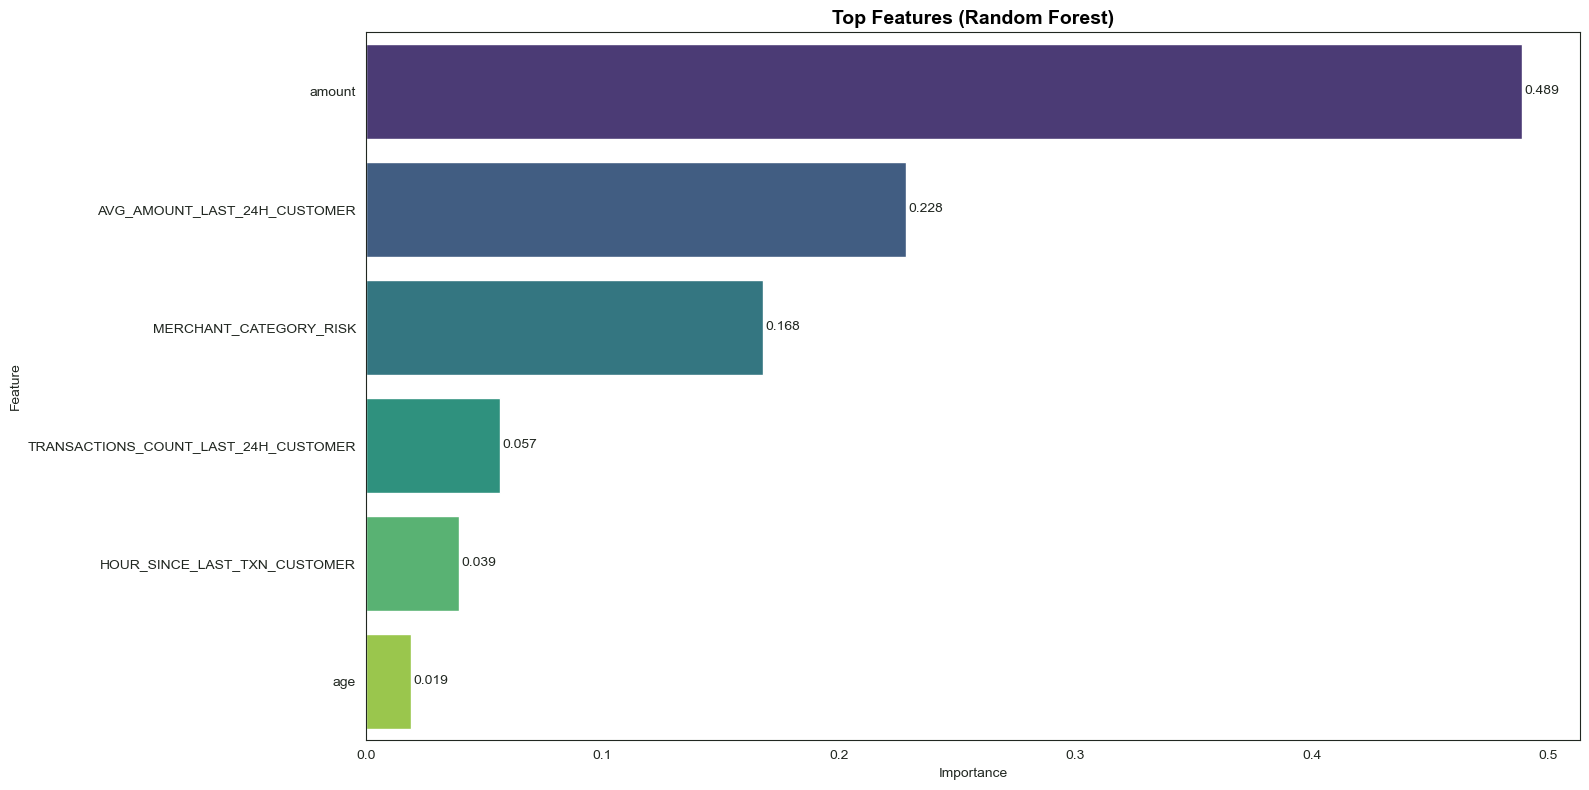

In [272]:
# Feature importances for tuned RF
rf_importances = tuned_rf.feature_importances_
features = X_train.columns

# Convert to DataFrame
rf_feat_df = pd.DataFrame({
    'feature': features,
    'importance': rf_importances
})

# Sort by importance descending
rf_feat_df = rf_feat_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x='importance', y='feature', data=rf_feat_df.head(20), palette="viridis")

# Add labels at the end of each bar
for i, imp in enumerate(rf_feat_df['importance'].head(20)):
    plt.text(imp + 0.001, i, f"{imp:.3f}", va='center', fontsize=10)

plt.title("Top Features (Random Forest)", color='black', fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [204]:
# Save tuned RF
rf_artifact = {
    'model': tuned_rf,
    'threshold': tuned_rf_threshold
}

with open("tuned_rf_model.pkl", "wb") as f:
    pickle.dump(rf_artifact, f)

print("Tuned RF model saved to tuned_rf_model.pkl")
# Usage below
# with open("tuned_rf_model.pkl", "rb") as f:
#     loaded_rf = pickle.load(f)

# model = loaded_rf['model']
# threshold = loaded_rf['threshold']

Tuned RF model saved to tuned_rf_model.pkl


<h3>XGBoost</h3>

In [221]:
# Baseline XGBoost
xgb_baseline = xgb.XGBClassifier(random_state=42) # using scale_pos_weight=80.6 would yield a very good recall 89% but 33% precision
xgb_baseline.fit(X_train, y_train)

# Probabilities for positive class
y_proba_xgb = xgb_baseline.predict_proba(X_test)[:, 1]

# Threshold
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Metrics
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC Score (XGBoost): {auc_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb))

AUC Score (XGBoost): 0.9948
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.88      0.68      0.77      1280

    accuracy                           1.00    118638
   macro avg       0.94      0.84      0.88    118638
weighted avg       1.00      1.00      1.00    118638



In [243]:
# Baseline XGBClassifier 
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1
)

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 80.6] #scale_pos_weight ≈ 1 / 0.0124 ≈ 80.6
}

# Stratified 5-fold CV
cv_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    cv=cv_xgb,
    scoring='f1',  
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search_xgb.fit(X_train, y_train)

# Best parameters and F1
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best F1 Score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
Best F1 Score: 0.7953611747895596


In [244]:
# Optimizing threshold for the tuned model
best_xgb = grid_search_xgb.best_estimator_

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_proba_xgb = np.zeros(len(X_train))
oof_y = y_train.values

# OOF probabilities
for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_model = XGBClassifier(**grid_search_xgb.best_params_,
                              random_state=42,
                              n_jobs=-1,
                              use_label_encoder=False,
                              eval_metric='logloss')
    xgb_model.fit(X_tr, y_tr)
    oof_proba_xgb[val_idx] = xgb_model.predict_proba(X_val)[:, 1]

# Best threshold on OOF predictions
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores_xgb = [f1_score(oof_y, (oof_proba_xgb >= t).astype(int)) for t in thresholds]
xgb_threshold = thresholds[np.argmax(f1_scores_xgb)]

print("Best threshold from CV (XGB):", xgb_threshold)
print("Best F1 from CV (XGB):", max(f1_scores_xgb))

C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:59:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:59:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:59:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:00:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

Best threshold from CV (XGB): 0.46
Best F1 from CV (XGB): 0.7943713118474807


In [247]:
# Tuned XGB Model
tuned_xgb = grid_search_xgb.best_estimator_

# Best XGB Threshold (from OOF tuning)
tuned_xgb_threshold = 0.46  

# Predict probabilities on the test set
y_proba_xgb = tuned_xgb.predict_proba(X_test)[:, 1]

# Apply threshold
y_pred_xgb = (y_proba_xgb >= tuned_xgb_threshold).astype(int)

# Metrics
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC Score (Tuned XGB): {auc_xgb:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

AUC Score (Tuned XGB): 0.9957
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.86      0.71      0.78      1280

    accuracy                           1.00    118638
   macro avg       0.93      0.85      0.89    118638
weighted avg       1.00      1.00      1.00    118638



C:\Users\User\AppData\Local\Temp\ipykernel_22516\2092491546.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20), palette="viridis")


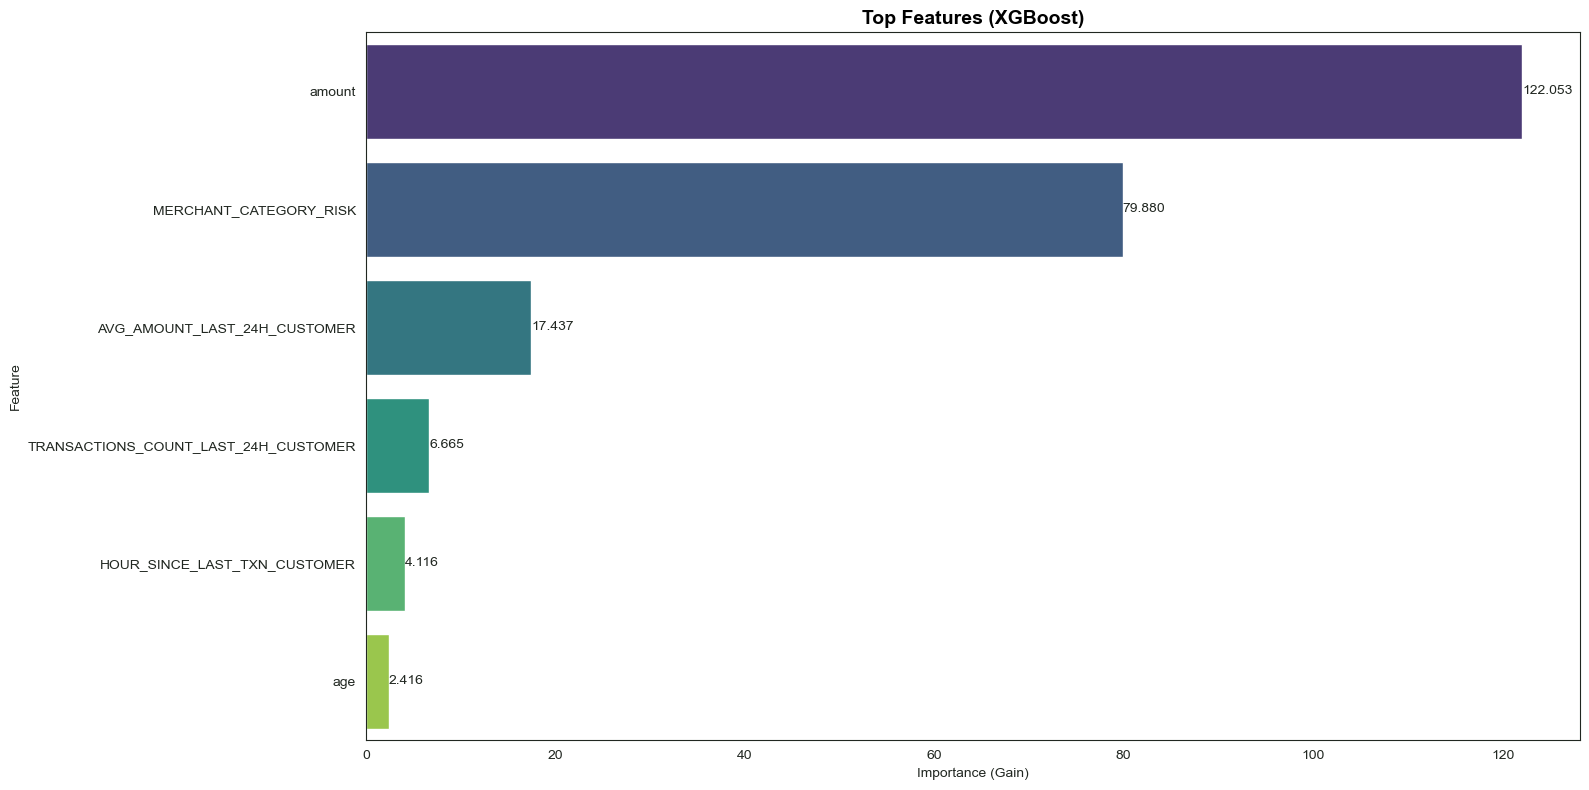

In [274]:
# Get feature importances
importances = tuned_xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
feat_imp_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20), palette="viridis")

# Add labels at the end of each bar
for i, (imp) in enumerate(feat_imp_df['importance'].head(20)):
    plt.text(imp + 0.01, i, f"{imp:.3f}", va='center', fontsize=10)
plt.title("Top Features (XGBoost)", color='black', fontsize=14)
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [262]:
# Save tuned XGB
xgb_artifact = {
    'model': tuned_xgb,
    'threshold': xgb_threshold
}

with open("tuned_xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_artifact, f)

print("Tuned XGB model saved to tuned_xgb_model.pkl")

# Usage example
# with open("tuned_xgb_model.pkl", "rb") as f:
#     loaded_xgb = pickle.load(f)
# 
# model = loaded_xgb['model']
# threshold = loaded_xgb['threshold']

Tuned XGB model saved to tuned_xgb_model.pkl


<h3>Gradient Boosting - LGBM Classifier</h3>

In [125]:
# Baseline LightGBM
lgb_baseline = lgb.LGBMClassifier(
    random_state=42
)
lgb_baseline.fit(X_train, y_train)

# Probabilities for the positive class
y_proba_lgb = lgb_baseline.predict_proba(X_test)[:, 1]

# Threshold
y_pred_lgb = (y_proba_lgb >= 0.5).astype(int)

# Metrics
auc_lgb = roc_auc_score(y_test, y_proba_lgb)
print(f"AUC Score (LightGBM): {auc_lgb:.4f}")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 5920, number of negative: 470085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 476005, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012437 -> initscore=-4.374577
[LightGBM] [Info] Start training from score -4.374577
AUC Score (LightGBM): 0.9955
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.89      0.68      0.77      1280

    accuracy                           1.00    118638
   macro avg       0.94      0.84      0.88    118638
weighted avg       1.00      1.00      1.00    118638



In [130]:
# Baseline LGBMClassifier
lgbm_clf = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

# Parameter grid for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 80.6]
}

# Stratified 5-fold CV
cv_lgbm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_clf,
    param_grid=param_grid_lgbm,
    cv=cv_lgbm,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search_lgbm.fit(X_train, y_train)

# Best parameters and F1
print("Best Parameters:", grid_search_lgbm.best_params_)
print("Best F1 Score:", grid_search_lgbm.best_score_)

# Predict on test data using the best model
best_lgbm = grid_search_lgbm.best_estimator_
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
y_pred_lgbm = (y_proba_lgbm >= 0.5).astype(int)

# Evaluate
auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
print(f"AUC Score (LightGBM): {auc_lgbm:.4f}")
print(classification_report(y_test, y_pred_lgbm))


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\User\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 5920, number of negative: 470085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 476005, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012437 -> initscore=-4.374577
[LightGBM] [Info] Start training from score -4.374577
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
Best F1 Score: 0.7972595603138276
AUC Score (LightGBM): 0.9957
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.89      0.68      0.77      1280

    accuracy                           1.00    118638
   macro avg     

In [138]:
# Best params from GridSearchCV
best_params_lgbm = grid_search_lgbm.best_params_

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_proba_lgbm = np.zeros(len(X_train))
oof_y = y_train.values

# Out-of-fold probabilities
for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lgbm_model = lgb.LGBMClassifier(
        **best_params_lgbm,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )
    lgbm_model.fit(X_tr, y_tr)
    oof_proba_lgbm[val_idx] = lgbm_model.predict_proba(X_val)[:, 1]

# Search for best threshold
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores_lgbm = [f1_score(oof_y, (oof_proba_lgbm >= t).astype(int)) for t in thresholds]
lgbm_threshold = thresholds[np.argmax(f1_scores_lgbm)]

print("Best threshold from CV (LightGBM):", lgbm_threshold)
print("Best F1 from CV (LightGBM):", max(f1_scores_lgbm))

Best threshold from CV (LightGBM): 0.49
Best F1 from CV (LightGBM): 0.7978997789240972


In [140]:
# Tuned LightGBM
tuned_lgbm = grid_search_lgbm.best_estimator_

# Best Threshold
tuned_lgbm_threshold = 0.49  

# Prbabilities for the positive class
y_proba_lgbm = tuned_lgbm.predict_proba(X_test)[:, 1]

# Apply custom threshold
y_pred_lgbm = (y_proba_lgbm >= tuned_lgbm_threshold).astype(int)

# Metrics
auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
print(f"AUC Score (Tuned LightGBM): {auc_lgbm:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

AUC Score (Tuned LightGBM): 0.9957
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.89      0.68      0.77      1280

    accuracy                           1.00    118638
   macro avg       0.94      0.84      0.88    118638
weighted avg       1.00      1.00      1.00    118638



C:\Users\User\AppData\Local\Temp\ipykernel_13028\1910004914.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20), palette="viridis")


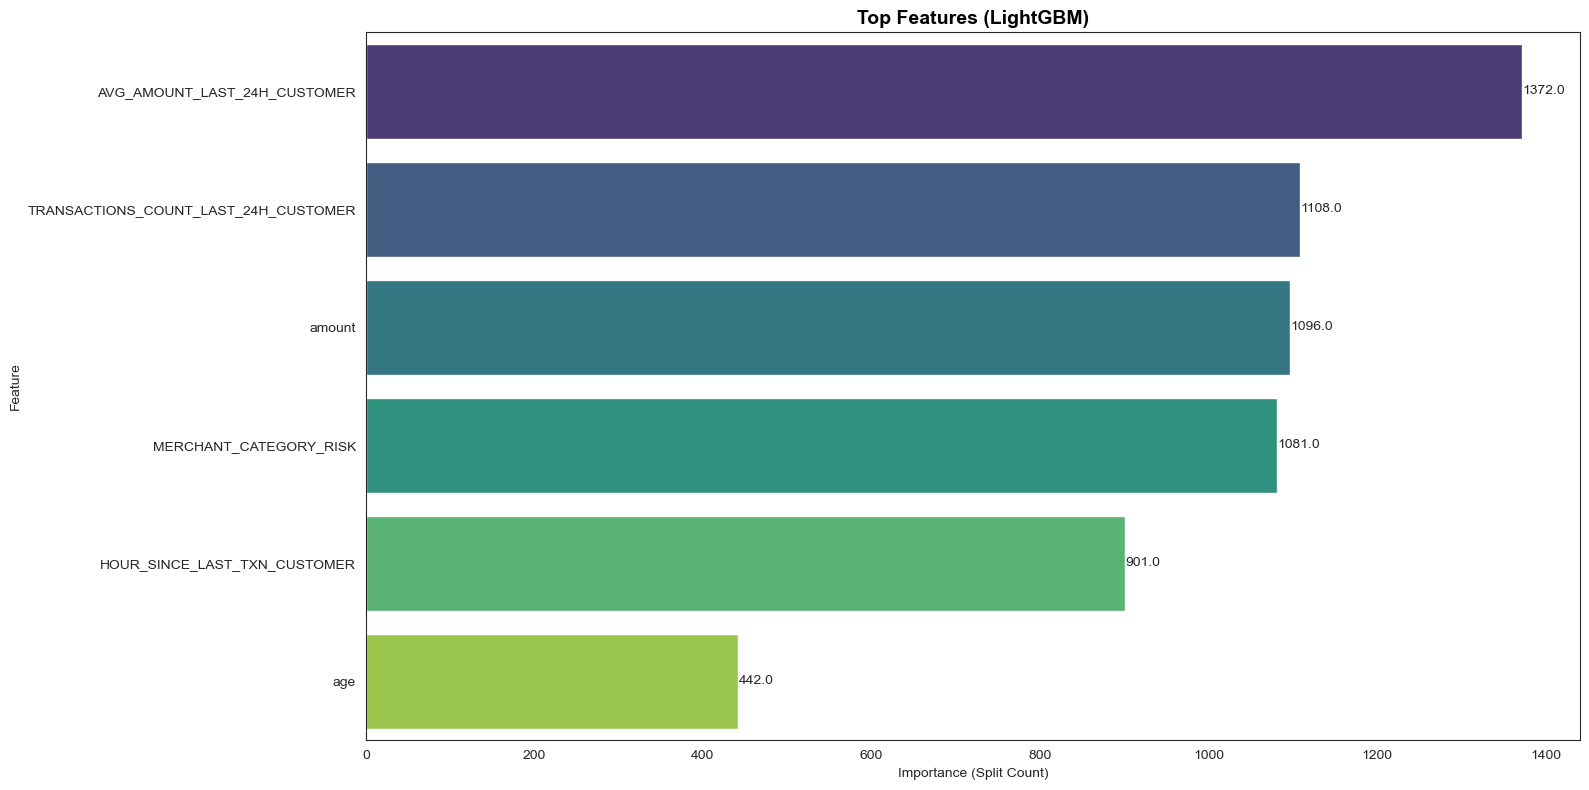

In [142]:
# Get feature importances
importances = tuned_lgbm.feature_importances_
features = tuned_lgbm.feature_name_
feat_imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20), palette="viridis")

# Add labels at the end of each bar
for i, imp in enumerate(feat_imp_df['importance'].head(20)):
    plt.text(imp + 0.5, i, f"{imp:.1f}", va='center', fontsize=10)

plt.title("Top Features (LightGBM)", color='black', fontsize=14)
plt.xlabel("Importance (Split Count)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [144]:
# Save tuned LightGBM
lgbm_artifact = {
    'model': tuned_lgbm,
    'threshold': lgbm_threshold
}

with open("tuned_lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm_artifact, f)

print("Tuned LightGBM model saved to tuned_lgbm_model.pkl")

# Usage example (loading it back)
# with open("tuned_lgbm_model.pkl", "rb") as f:
#     loaded_lgbm = pickle.load(f)
#
# model = loaded_lgbm['model']
# threshold = loaded_lgbm['threshold']

Tuned LightGBM model saved to tuned_lgbm_model.pkl


<h3>SMOTE with the above 3</h3

In [148]:
def smote_grid_search(estimator, param_grid, X, y, scoring='f1', n_splits=5):
    """
    Wraps SMOTE + Model(Estimator) into a pipeline and runs GridSearchCV.
    Returns the fitted GridSearchCV object.
    """
    pipe = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', estimator)
    ])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid={'model__' + k: v for k, v in param_grid.items()},
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X, y)
    return grid

In [156]:
# Random Forest
rf_params =  {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 80.6]
}

# LightGBM
lgbm_params = param_grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 80.6]
}

# Fit each
rf_grid = smote_grid_search(RandomForestClassifier(random_state=42, n_jobs=-1), rf_params, X_train, y_train)
xgb_grid = smote_grid_search(XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'), xgb_params, X_train, y_train)
lgbm_grid = smote_grid_search(LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1), lgbm_params, X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\User\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


NameError: name 'LGBMClassifier' is not defined

In [158]:
xgb_grid

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 6, 10],
                         'model__n_estimators': [100, 200],
                         'model__scale_pos_weight': [1, 80.6],
                         'model__subsample': [0.8, 1.0]},
             scoring='f1', verbose=2)

In [165]:
lgbm_grid = smote_grid_search(lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1), lgbm_params, X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\User\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [166]:
# Threshold Tuning
def find_best_threshold(estimator, X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_proba = np.zeros(len(X))
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        estimator.fit(X_tr, y_tr)
        oof_proba[val_idx] = estimator.predict_proba(X_val)[:, 1]

    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [f1_score(y, (oof_proba >= t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1_scores)]
    return best_t, max(f1_scores)

rf_threshold, rf_f1   = find_best_threshold(rf_grid.best_estimator_,  X_train, y_train)
xgb_threshold, xgb_f1 = find_best_threshold(xgb_grid.best_estimator_, X_train, y_train)
lgbm_threshold, lgbm_f1 = find_best_threshold(lgbm_grid.best_estimator_, X_train, y_train)

In [167]:
def evaluate_on_test(pipeline, X_test, y_test, threshold, model_name):
    """
    Applies fitted pipeline to test set and prints metrics.
    """
    # Predict probabilities on the test set
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Apply chosen threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Metrics
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n===== {model_name} on Test Set =====")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

# Example usage with your tuned models/thresholds:
evaluate_on_test(rf_grid.best_estimator_,  X_test, y_test, rf_threshold,  "Random Forest")
evaluate_on_test(xgb_grid.best_estimator_, X_test, y_test, xgb_threshold, "XGBoost")
evaluate_on_test(lgbm_grid.best_estimator_, X_test, y_test, lgbm_threshold,"LightGBM")


===== Random Forest on Test Set =====
AUC: 0.9925
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.83      0.66      0.74      1280

    accuracy                           0.99    118638
   macro avg       0.92      0.83      0.87    118638
weighted avg       0.99      0.99      0.99    118638


===== XGBoost on Test Set =====
AUC: 0.9932
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.90      0.65      0.76      1280

    accuracy                           1.00    118638
   macro avg       0.95      0.83      0.88    118638
weighted avg       1.00      1.00      1.00    118638


===== LightGBM on Test Set =====
AUC: 0.9921
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117358
           1       0.88      0.66      0.76      1280

    accuracy                           1

In [168]:
def save_model(model, threshold, filename):
    artifact = {'model': model, 'threshold': threshold}
    with open(filename, 'wb') as f:
        pickle.dump(artifact, f)
        
save_model(rf_grid.best_estimator_, rf_threshold, "tuned_rf_smote.pkl")
save_model(xgb_grid.best_estimator_, xgb_threshold, "tuned_xgb_smote.pkl")
save_model(lgbm_grid.best_estimator_, lgbm_threshold, "tuned_lgbm_smote.pkl")


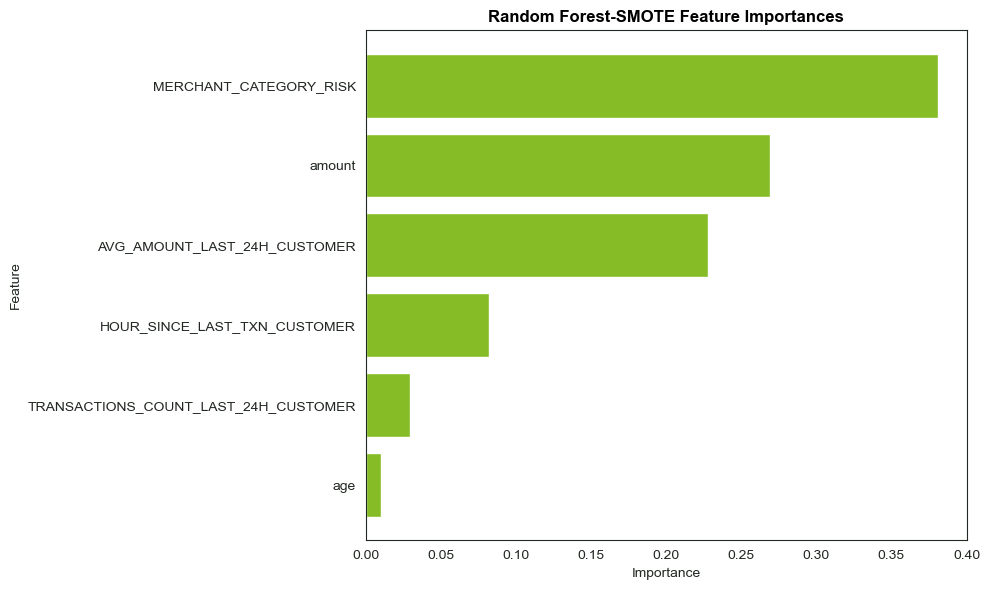

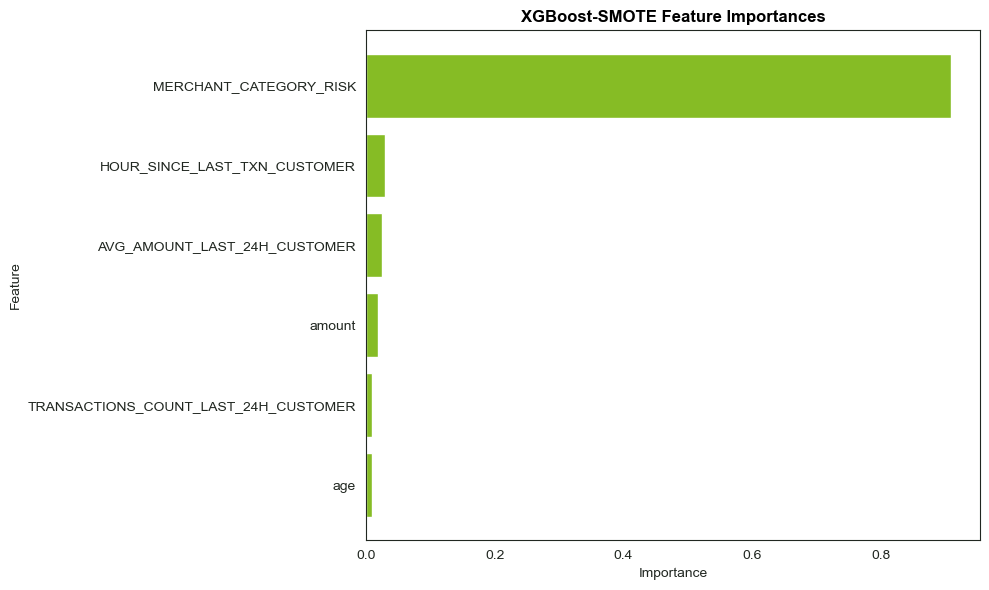

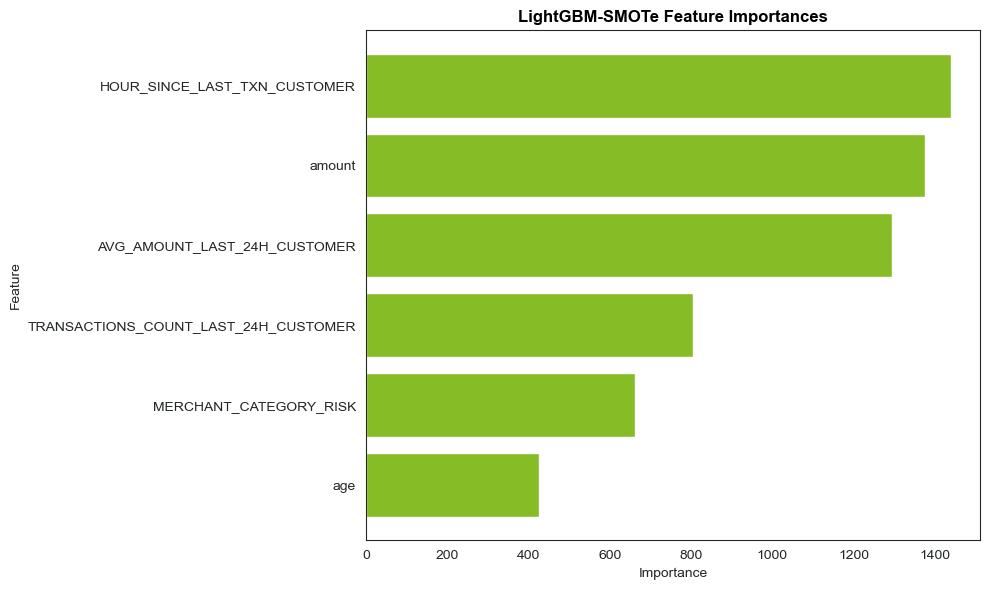

In [185]:
def plot_feature_importances(model, feature_names, top_n=20, title="Feature Importances"):
    """Plots top_n feature importances for a fitted model."""
    # Get feature importances depending on model type
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_booster'):  # XGBoost
        importances_dict = model.get_booster().get_score(importance_type='gain')
        importances = np.array([importances_dict.get(f, 0) for f in feature_names])
    else:
        raise ValueError("Model does not have feature importances attribute")

    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['feature'][:top_n][::-1],
             feat_imp_df['importance'][:top_n][::-1])
    plt.title(title,color='black')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
rf_model = rf_grid.best_estimator_.named_steps['model']
xgb_model = xgb_grid.best_estimator_.named_steps['model']
lgbm_model = lgbm_grid.best_estimator_.named_steps['model']

feature_names = X_train.columns  # or the list of your features

plot_feature_importances(rf_model, feature_names, title="Random Forest-SMOTE Feature Importances")
plot_feature_importances(xgb_model, feature_names, title="XGBoost-SMOTE Feature Importances")
plot_feature_importances(lgbm_model, feature_names, title="LightGBM-SMOTe Feature Importances")